In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba,to_rgb

In [4]:
# Compute pseudoinverse with rank truncation
# This is used in the DMD algorithm
def my_pinv(X,rank):
    U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    Σ[rank:] = 0.0
    return Vh.T.conj() @ np.linalg.pinv(np.diag(Σ)) @ U.T.conj()

# Ignore all eigenvalues equal to 0
def nonzero_filter(eigs):
    return eigs[np.abs(eigs)>1e-12]
    

n=10,T=31,k=6
Normal Reconstruction 2.248871967327086e-12
Centered Reconstruction 2.1705491504795145e-12

n=10,T=31,k=10
Normal Reconstruction 0.019138843811055222
Centered Reconstruction 7.049620456203252e-12

n=30,T=11,k=6
Normal Reconstruction 3.6234398716786626e-13
Centered Reconstruction 3.801260916660314e-14

n=30,T=11,k=14
Normal Reconstruction 5.4602334473854134e-14
Centered Reconstruction 1.5911547941206153e-14



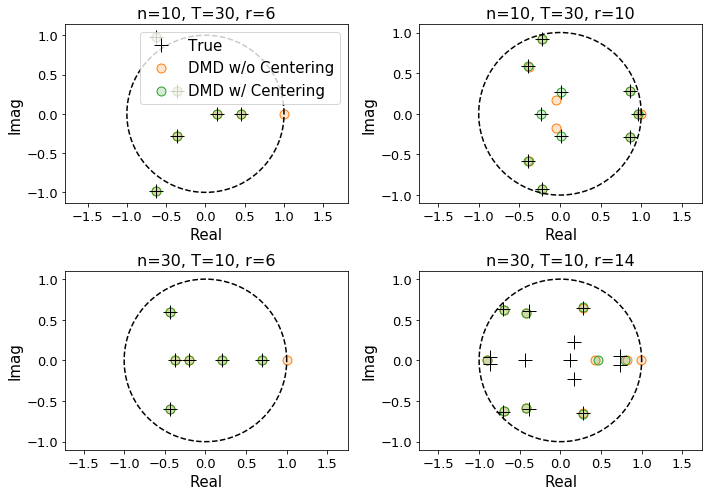

In [9]:
# Run all the DMD's
np.random.seed(4)
n_features = (10,10,30,30)
T_time_steps = (31,31,11,11)
num_eigenvals = (6,10,6,14)

plt.figure(figsize=(10,7))
for j,(_n_features, _T_time_steps,_num_eigenvals) in enumerate(zip(n_features,T_time_steps,num_eigenvals)):
    
    # Generate data
    x0 = np.random.randn(_n_features)  
    rand_mat = np.random.randn(_n_features,_n_features) / np.sqrt(_n_features) 
    U,Σ,Vh = np.linalg.svd(rand_mat)
    sig = np.zeros((_n_features,_n_features))
    sig[range(_num_eigenvals),range(_num_eigenvals)] = Σ[:_num_eigenvals] # Constrain 
    A = U @ sig @ Vh
    trunc_eigenvals = np.linalg.eig(A)[0]
    b =  np.random.randn(_n_features) * 1.0
    
    t = np.arange(_T_time_steps)
    X = np.zeros((_n_features,_T_time_steps+1),dtype=complex)
    X[:,0] = x0
    for i in range(1,_T_time_steps+1):
        X[:,i] = A @ X[:,i-1] + b
    # We throw out the initial point so that all the data is in the range of A
    # This enforces the fact that the number of nonzero eigenvalues of A is the rank of X_1
    X = X[:,1:]
    
    # Normal Solution (related to exactDMD)
    normal_alg = {}
    normal_alg['A'] = X[:,1:] @ my_pinv(X[:,:-1],_num_eigenvals+1)
    normal_alg['label'] = 'DMD w/o Centering'
    normal_alg['color'] = 'tab:orange'

    # Centered solution (related to centering your data)
    centered_alg = {}
    μ1 = X[:,:-1].mean(axis=1)
    μ2 = X[:,1:].mean(axis=1)
    centered_alg['A'] = (X[:,1:] - μ2[:,np.newaxis]) @ my_pinv(X[:,:-1] - μ1[:,np.newaxis],_num_eigenvals)
    centered_alg['b'] = μ2 - centered_alg['A'].dot(μ1)
    centered_alg['label'] = 'DMD w/ Centering'
    centered_alg['color'] = 'tab:green'

    # Make tuple of all algorithms
    algs = (normal_alg,centered_alg)

    print('n=' + str(_n_features) + ',' + 'T=' + str(_T_time_steps) + ',' + 'k=' + str(_num_eigenvals))
    print('Normal Reconstruction',np.linalg.norm(X[:,1:] - normal_alg['A'].dot(X[:,:-1])))
    print('Centered Reconstruction',np.linalg.norm(X[:,1:] - centered_alg['A'].dot(X[:,:-1]) - np.outer(centered_alg['b'],np.ones(_T_time_steps-1))))
    print()

    plt.subplot(2,2,j+1)
    for method in algs:
        eigenvals, eigenvects = np.linalg.eig(method['A'])
        plt.scatter(np.real(nonzero_filter(eigenvals)),np.imag(nonzero_filter(eigenvals)),
                    label=method['label'],c=(*to_rgb(method['color']),0.2),
                            s=80,edgecolors=(*to_rgb(method['color']),1.0))

    true_eig,_ = np.linalg.eig(A)
    plt.plot(np.real(nonzero_filter(true_eig)),np.imag(nonzero_filter(true_eig)),'k+',markersize=14,label='True')

    temp = np.linspace(0,1,100)
    x = np.cos(2*np.pi*temp)
    y = np.sin(2*np.pi*temp)
    plt.plot(x,y, 'k--')
    plt.axis('equal')
    

    plt.title('n=' + str(_n_features) + ', ' + 'T=' + str(_T_time_steps-1) + ', ' + 'r=' + str(int(np.min((_num_eigenvals,_n_features)))),fontsize=16)
    plt.ylabel('Imag',fontsize=15)
    plt.xlabel('Real',fontsize=15)
    if j == 0:
        plt.legend(loc=1,fontsize=15)
    
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
plt.tight_layout()
plt.savefig('../Writeup/Figures/DMDwithandwithoutcentering.png',dpi=300)